## The Viscoacoustic seismic wave equations 

In this tutorial, three versions of viscoacoustic equations are implemented:

The first implementation is based in:

 - https://library.seg.org/doi/pdf/10.1190/1.1822695
 - https://library.seg.org/doi/pdf/10.1190/geo2013-0414.1 
 - https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf
 
The second implementation is based in:

 - https://academic.oup.com/gji/article/197/2/948/616510
 - https://link.springer.com/article/10.1007/s11770-014-0414-8
 - https://library.seg.org/doi/pdf/10.1190/geo2018-0022.1
 
The third implementation is based in:
 
 - https://library.seg.org/doi/pdf/10.1190/1.2714334
 


In [1]:
import numpy as np
import sympy as sp

from devito import *
from examples.seismic.source import RickerSource, WaveletSource, TimeAxis
from examples.seismic import ModelViscoacoustic, plot_image, setup_geometry, plot_velocity

In [2]:
nx = 300
nz = 300

# Define a physical size
shape = (nx, nz)   # Number of grid point (nx, nz)
spacing = (10., 10.)   # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
nlayers = 3
nbl = 50
space_order = 8
dtype = np.float32

# Model physical parameters:
vp = np.zeros(shape)
qp = np.zeros(shape)
rho = np.zeros(shape)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5

# Define a velocity profile in km/s
v = np.empty(shape, dtype=dtype)
v[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

qp[:] = 3.516*((v[:]*1000.)**2.2)*10**(-6) # Li's empirical formula

rho[:] = 0.31*(v[:]*1000.)**0.25 # Gardner's relation

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


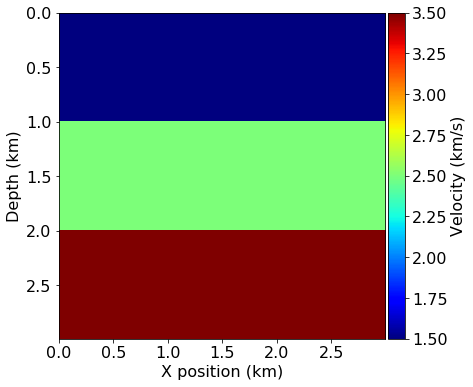

In [3]:
#NBVAL_IGNORE_OUTPUT
# Create model
model = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, rho=rho, 
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)

plot_velocity(model)

In [4]:
f0 = 0.010 # peak/dominant frequency 
rho = model.rho
irho = model.irho

# velocity model
vp = model.vp

t_s = (sp.sqrt(1.+1./model.qp**2)-1./model.qp)/f0
t_ep = 1./(f0**2*t_s)
tt = (t_ep/t_s) - 1.

s = model.grid.stepping_dim.spacing
damp = model.damp

In [5]:
# Time step in ms and time range:
t0, tn = 0., 4000.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

In [6]:
from examples.seismic import Receiver

def src_rec(p, model):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.coordinates.data[0, -1] = 8.  

    # Create symbol for receivers
    rec = Receiver(name='rec', grid=model.grid, npoint=shape[0], time_range=time_range)

    # Prescribe even spacing for receivers along the x-axis
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec.coordinates.data[:, 1] = 8.  

    src_term = src.inject(field=p.forward, expr=(s*src))
    rec_term = rec.interpolate(expr=p.forward)
    
    return src_term + rec_term, src, rec

## Blanch and Symes (1995) / Dutta and Schuster (2014)

The equations of motion for a viscoacoustic medium can be written as:

\begin{equation}
\left\{
\begin{array}{lcl}
\frac{\partial P}{\partial t} + \kappa (\tau + 1)(\nabla \cdot {\bf v}) + r = f({\bf x}_{s}, t) \\
\frac{\partial {\bf v}}{\partial t} + \frac{1}{\rho}\nabla{P} = 0 \\
\frac{\partial r}{\partial t} + \frac{1}{\tau_{\sigma}} [r + \tau \kappa (\nabla \cdot {\bf v})] = 0.
\end{array}
\right.
\label{first-order-dutta}
\end{equation}


Where $\rho({\bf x})$ is the density, $\kappa=\kappa({\bf x})$ is the bulk modulus, $Q({\bf x})$ is the quality factor, $P({\bf x},t)$ denotes the pressure field, ${\bf v} = {\bf v}({\bf x},t)$ is the particle velocity vector and $f=f({\bf x}_{s},t)$ is the source position at ${\bf x} = {\bf x}_{s}$.

$\tau = \tau_{\epsilon}/\tau_{\sigma} -1$ represents the magnitude of  $Q$. $\tau_{\epsilon}$ and $\tau_{\sigma}$ are, respectively, the stress e strain relaxation parameters, given by:

\begin{equation}
\tau_\sigma = \frac{\sqrt{Q^2+1}-1}{2 \pi f_0 Q}
\end{equation}
and
\begin{equation}
\tau_\epsilon= \frac{\sqrt{Q^2+1}+1}{2\pi f_0 Q}
\end{equation}


In [7]:
# Stencil created from Blanch and Symes (1995) / Dutta and Schuster (2014) 
def viscoacoustic_blanch_symes(model, p, r, v):

    # Bulk modulus
    bm = rho * (vp * vp)

    # Define PDE to v
    pde_v = v - s * irho * grad(p)

    u_v = Eq(v.forward, damp * pde_v)    

    # Define PDE to r
    pde_r = r - s * (1. / t_s) * r - s * (1. / t_s) * tt * bm * div(v.forward)

    u_r = Eq(r.forward, damp * pde_r)

    # Define PDE to p
    pde_p = p - s * bm * (tt + 1.) * div(v.forward) - s * r.forward

    u_p = Eq(p.forward, damp * pde_p) 
    
    return [u_v, u_r, u_p]

In [8]:
# Seismic Modelling from Blanch and Symes (1995) / Dutta and Schuster (2014) viscoacoustic wave equation.
def modelling_blanch_symes(model):
    
    # Create symbols for particle velocity, pressure field, memory variable, source and receivers
    
    v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=space_order)

    p = TimeFunction(name="p", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)

    r = TimeFunction(name="r", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)
    
    # define the source injection and create interpolation expression for receivers
    
    src_rec_expr, src, rec = src_rec(p, model)
    
    eqn = viscoacoustic_blanch_symes(model, p, r, v)
    
    op = Operator(eqn + src_rec_expr, subs=model.spacing_map)
    
    op(time=time_range.num-1, dt=dt, src=src, rec=rec)
    
    return rec, v, p

In [9]:
rec, v, p = modelling_blanch_symes(model)

Operator `Kernel` run in 14.72 s


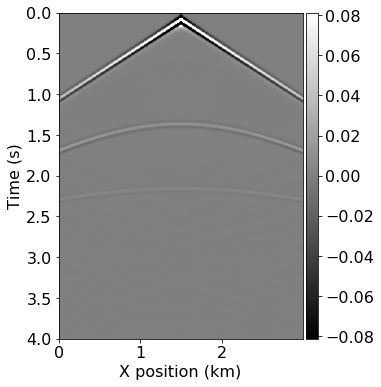

In [10]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [11]:
assert np.isclose(np.linalg.norm(rec.data), 16, rtol=10)

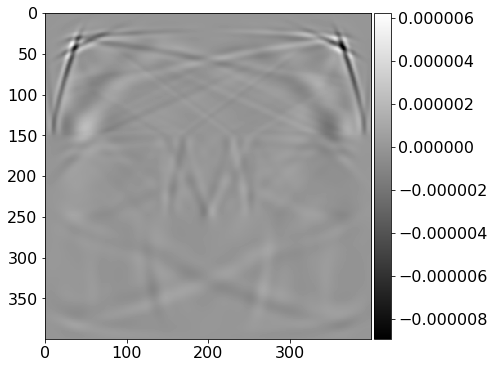

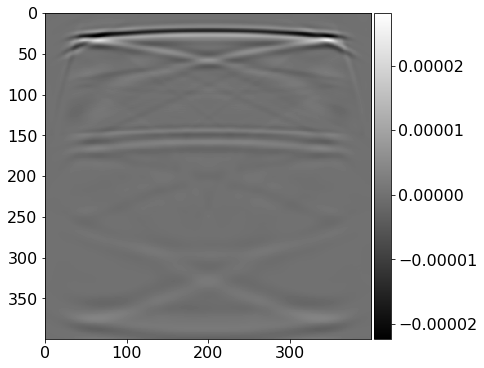

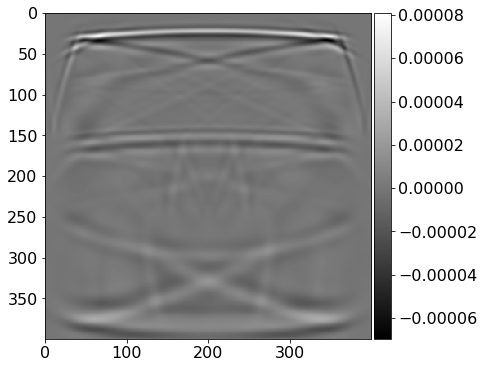

In [12]:
#NBVAL_IGNORE_OUTPUT
plot_image(v[0].data[0])
plot_image(v[1].data[0])
plot_image(p.data[0])

In [13]:
#NBVAL_IGNORE_OUTPUT
assert np.isclose(norm(v[0]), 0.000204185, atol=1e-4, rtol=0)

## Ren et al. (2014)

The viscoacoustic wave equation in time domain is written as:

\begin{equation}
\frac{\partial^{2}P}{\partial{t^2}} - v^{2}\nabla^{2}{P} - \eta\nabla^{2}\left(\frac{\partial P}{\partial t}\right) = f({\bf x}_{s}, t),
\end{equation}

where $\eta = \frac{v^2}{\omega_{0}Q}$ represents the viscosity of medium, $\omega_{0}=2 \pi f_{0}$ is the angular frequency. $f_{0}$ is the dominant frequency.

Considering the variable density $\rho$, the equation can be rewritten as:

\begin{equation}
\frac{\partial^{2}P}{\partial{t^2}} - \kappa \nabla \cdot \frac{1}{\rho} \nabla{P} - \eta \rho \nabla \cdot \frac{1}{\rho} \nabla \left(\frac{\partial{P}}{\partial{t}}\right) = f({\bf x}_{s}, t).
\end{equation}

The equation can be written using a first order formulation, given by:

\begin{equation}
\left\{
\begin{array}{ll}
\frac{\partial P}{\partial t} + \kappa \nabla \cdot {\bf v} - \eta \rho \nabla \cdot \frac{1}{\rho} \nabla{P} = f({\bf x}_{s}, t) \\
\frac{\partial {\bf v}}{\partial t} + \frac{1}{\rho} \nabla{P} = 0
\end{array}
\right.
\end{equation}

In [14]:
# Stencil created from Ren et al. (2014) viscoacoustic wave equation.
def viscoacoustic_ren(model, p, v):

    # Angular frequency 
    w = 2. * np.pi * f0

    # Define PDE to v
    pde_v = v - s * irho * grad(p)

    u_v = Eq(v.forward, damp * pde_v)

    # Define PDE to p
    pde_p = p - s * vp * vp * rho * div(v.forward) + s * \
            ((vp * vp * rho) / (w * model.qp)) * div(irho * grad(p))

    u_p = Eq(p.forward, damp * pde_p) 
    
    return [u_v, u_p]

In [15]:
# Seismic Modelling from Ren et al. (2014) viscoacoustic wave equation.
def modelling_ren(model):
    
    # Create symbols for particle velocity, pressure field, source and receivers

    v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=space_order)

    p = TimeFunction(name="p", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)

    # define the source injection and create interpolation expression for receivers
    
    src_rec_expr, src, rec = src_rec(p, model)
    
    eqn = viscoacoustic_ren(model, p, v)
    
    op = Operator(eqn + src_rec_expr, subs=model.spacing_map)
    
    op(time=time_range.num-1, dt=dt, src=src, rec=rec)
    
    return rec, v, p

In [16]:
rec, v, p = modelling_ren(model)

Operator `Kernel` run in 76.79 s


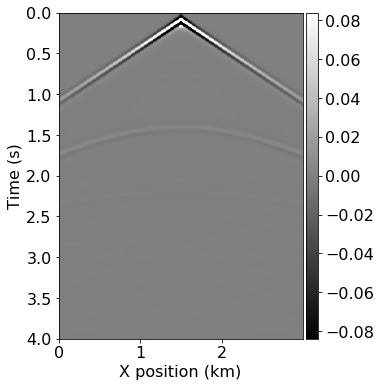

In [17]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [18]:
assert np.isclose(np.linalg.norm(rec.data), 15, rtol=10)

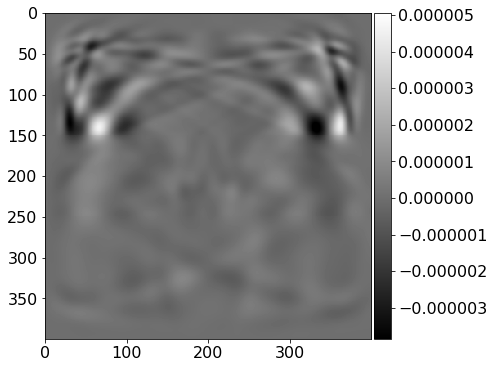

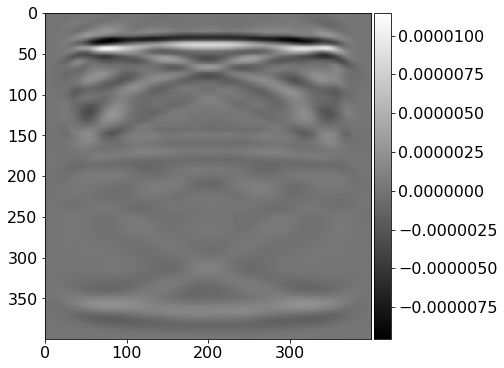

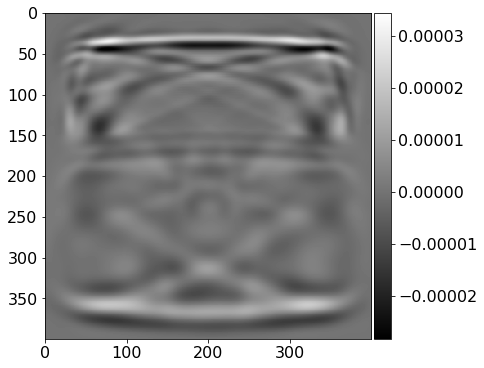

In [19]:
#NBVAL_IGNORE_OUTPUT
plot_image(v[0].data[0])
plot_image(v[1].data[0])
plot_image(p.data[0])

In [20]:
assert np.isclose(norm(v[0]), 0.000387120, atol=1e-4, rtol=0)

## Deng and McMechan (2007)

The viscoacoustic wave equation for the propagating pressure $P$ in the time-space domain:

\begin{equation}
\frac{1}{v^2}\frac{\partial^{2}P}{\partial{t^2}} - \nabla^{2}P + \frac{g}{v}\frac{\partial P}{\partial{t}}  = f({\bf x}_{s}, t),
\label{eq-deng}
\end{equation}

where $g$ is the absorption coefficient, given by:

\begin{equation}
g = \frac{2\pi f_{0}}{vQ},
\end{equation}

The equation can be written using a first order formulation, given by:

\begin{equation}
\left\{
\begin{array}{lcl}
\frac{\partial P}{\partial t} + \kappa (\nabla \cdot {\bf v}) + \frac{2\pi f_{0}}{Q}P= f({\bf x}_{s}, t) \\
\frac{\partial {\bf v}}{\partial t} + \frac{1}{\rho}\nabla{P} = 0 \\
\end{array}
\right.
\end{equation}


In [21]:
# Stencil created from Deng and McMechan (2007) viscoacoustic wave equation.
def viscoacoustic_deng_mcmechan(model, p, v):

    # Angular frequency 
    w = 2. * np.pi * f0

    # Define PDE to v
    pde_v = v - s * irho * grad(p)
  
    u_v = Eq(v.forward, damp * pde_v)

    # Define PDE to p
    pde_p = p - s * vp * vp * rho * div(v.forward) - s * (w / model.qp) * p

    u_p = Eq(p.forward, damp * pde_p) 
    
    return [u_v, u_p]

In [22]:
# Seismic Modelling from Deng and McMechan (2007) viscoacoustic wave equation.
def modelling_deng_mcmechan(model):
    
    # Create symbols for particle velocity, pressure field, source and receivers
    
    v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=space_order)

    p = TimeFunction(name="p", grid=model.grid, time_order=1, space_order=space_order, 
                     staggered=NODE)

    # define the source injection and create interpolation expression for receivers
    
    src_rec_expr, src, rec = src_rec(p, model)
    
    eqn = viscoacoustic_deng_mcmechan(model, p, v)
    
    op = Operator(eqn + src_rec_expr, subs=model.spacing_map)
    
    op(time=time_range.num-1, dt=dt, src=src, rec=rec)
    
    return rec, v, p

In [23]:
rec, v, p = modelling_deng_mcmechan(model)

Operator `Kernel` run in 11.93 s


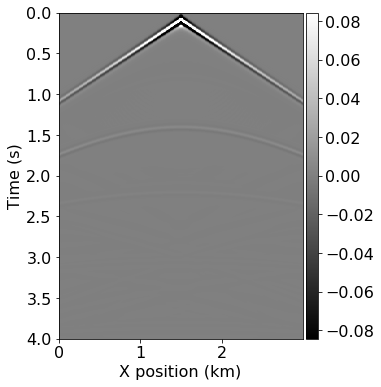

In [24]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [25]:
assert np.isclose(np.linalg.norm(rec.data), 16, rtol=10)

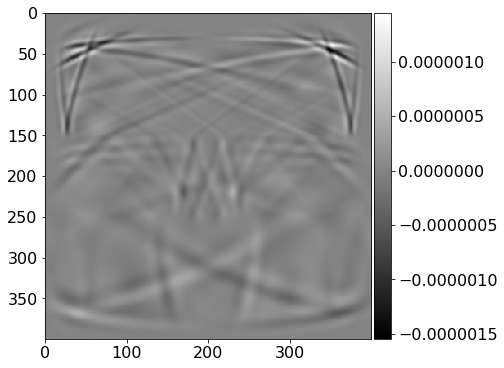

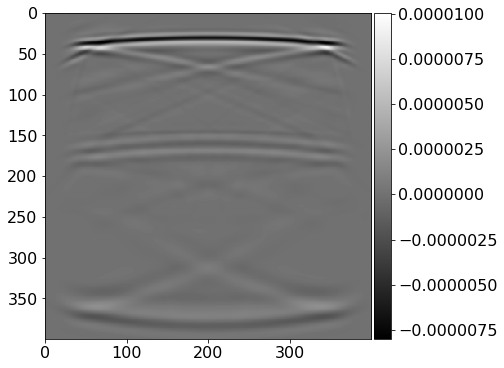

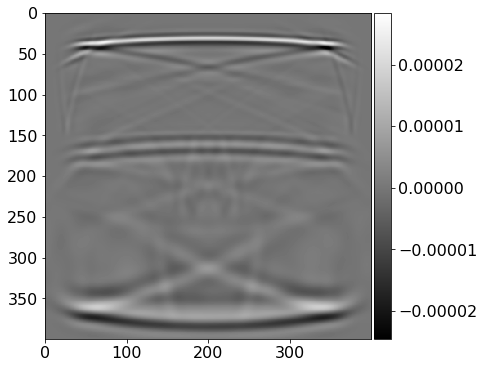

In [26]:
#NBVAL_IGNORE_OUTPUT
plot_image(v[0].data[0])
plot_image(v[1].data[0])
plot_image(p.data[0])

In [27]:
assert np.isclose(norm(v[0]), 0.000037954, atol=1e-4, rtol=0)

# References

[1] https://library.seg.org/doi/pdf/10.1190/1.1822695

[2] https://library.seg.org/doi/pdf/10.1190/geo2013-0414.1

[3] https://academic.oup.com/gji/article/197/2/948/616510

[4] https://link.springer.com/article/10.1007/s11770-014-0414-8

[5] https://library.seg.org/doi/pdf/10.1190/geo2018-0022.1

[6] https://library.seg.org/doi/pdf/10.1190/1.2714334

[7] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf